In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

interpreting accuracy and exploring further evaluation metrics

### Prep from last week (training model etc.)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [37]:
df = pd.read_csv('../wk03-classification/data-week-3.csv')

In [38]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [39]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [40]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [41]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [42]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

### Accuracy & Dummy Model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [43]:
all = len(y_val)

In [44]:
correct = (y_val == churn_decision).sum()

In [45]:
accuracy = correct / all
accuracy

np.float64(0.8034066713981547)

In [46]:
#here computing the mean is the same since all 0 and 1s
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [47]:
#scikit learn already has accuracy testing
from sklearn.metrics import accuracy_score

In [48]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [49]:
#try moving decision thresholds and seeing if this improves accuracy

thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.737
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


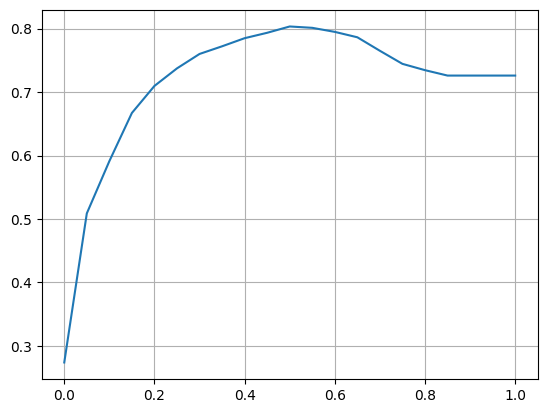

In [50]:
plt.plot(thresholds, scores)
plt.grid(True)

#0.5 indeed the best threshold

In [51]:
from collections import Counter

In [52]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

for every customer it predicts non-churning (?), and the accuracy for this model, that predicts every customer is non churning, is 73% which is only 7% less than our original 0.5 threshold model accuracy

In [53]:
Counter(y_val)
#there are a lot more non churning users

Counter({np.int64(0): 1023, np.int64(1): 386})

In [54]:
1 - y_val.mean() #non-churning percentage

np.float64(0.7260468417317246)

CLASS IMBALANCE 3:1, this is a case where accuracy can be quite a misleading score

### Confusion Table

- Different types of errors and correct decisions our model makes
- Arranging them in a table for better interpretation (confusion matrix)

Four groups: 
- true positive: y_pred >= t, y=1
- true negative: y_pred < t, y=0
- false positive: y_pred >= t, y=0
- false negative: y_pred < t, y=1

In [55]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [56]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [57]:
tp = (predict_positive & actual_positive).sum() # when both are true
tn = (predict_negative & actual_negative).sum() # when both are false

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [58]:
print("\ntp:", tp, "\ntn", tn, "\nfp:", fp, "\nfn:", fn)


tp: 210 
tn 922 
fp: 101 
fn: 176


In [59]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [60]:
(confusion_matrix / confusion_matrix.sum()).round(2) #normalize
#accuracy shown by sum of diagonal

array([[0.65, 0.07],
       [0.12, 0.15]])

### Precision and Recall

Precision tells us how many positive predictions turned out to be correct (fraction of positive correct predictions)

Precision = TP / total P = TP / (TP + FP)

In [66]:
p = tp / (tp + fp)
print("precision: ", round(100*p, 0))
p

precision:  68.0


np.float64(0.6752411575562701)

Recall is the fraction of correctly identified positive examples. How many of the churners were correctly identified.

Recall = TP / all churners = TP / (TP + FN)

In [65]:
r = tp / (tp + fn)
print("recall: ", round(100*r, 0))
r

recall:  54.0


np.float64(0.5440414507772021)

--> we failed to identify 1 - 0.54 = 46% of churners, so they didn't receive a promotional email that could have prevented them from churning.

### ROC Curves

ROC = Receiver Operating Characteristics

For this we are interested in false positive rate (FPR) and true positive rate (TPR) which we can get from confusion matrix

FPR = fraction of positives in negative examples = FP / (TN + FP)

TPR = fraction of positive in positive examples = TP / (FN + TP)